<a href="https://colab.research.google.com/github/nilsberzins/Adv-Computation-R-Portfolio/blob/main/Final_Project_DATA_301_%7C_Nils_Berzins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reasearch Questions


1. Can we predict the alcohol content of the wine based on the rest of a wine's psychochemical make up?

2. Regardless of the quality of wines being determined by expert wine reviewers, taste is subjective. Are experts truly able to discern differences in wine quality based on their psychochemical make up?


In [ ]:
from google.colab import drive

#Mounting My Drive for Easy Access to Wine Files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

# Data Description
Data from: https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub - however was collected on kaggle

Originally, the dataset was used by Cortez et al. (2009) to test the efficacy of Neural Networks and Suppot Vector Machines on a rich data set. I've simply appropriated the dataset to create more simplistic predictive models of wine quality based on the general psychochemical makeup of each observed wine.

Below are brief descriptions of the variables of interest in the dataset:


1.   **Fixed Acidity** (tartaric)($g/dm^3$) - Typically consists of most acids originally found in the grape (tartaric, malic, citric) that remain in the wine after the fermentation process. Can be thought of as the sharp or crisp taste in wines.

2.   **Volatile Acidity** (acetic)($g/dm^3$) - Evaporable acid that contribute to the aromatic experience a.k.a. "adding complexity". Too much is a fault in wine making and creates a "vinegary" taste in the wine.

3.   **Citric Acid** ($g/dm^3$)- One of the natrually present acids found in the grape. A unique taste profile when compared to tartaric and malic acid: contributes to the fresh, citrusy character to the wine.

4.   **Residual Sugar** ($g/dm^3$) - Natural grape sugars that remain in the wine after the fermentation process. Less sugar content leads to a "dry" taste whereas as more sugar content leads to a sweeter taste.

5.   **Chlorides** (sodium chloride)($g/dm^3$) - Typically natrually found in the grapes or a wine makers approach to terroir (soil content, closeness to salty water bodies, etc). Typically low enough levles of sodium such that there is not a perceptable "salty" taste, but rather acts as an amplifier to preexisiting flavors.

6.   **Free/Total Sulfur Dioxoide** ($mg/dm^3$) - Antioxidant and antimicrobial additive. In essence, it preserves the aromatics of the wine, therefore creating longer lasting fruity/vibrant flavors.

7.   **Density** ($mg/cm^3$) - Can be thought of as how concentrated the wine is, not in and of itself indivcative of flavor. For example, higher alcohol content leads to lower density, higher sugar content leads to higher density.

8.   **pH** - Low pH indates a higher acidity, and vice versa. Taste profile highlgy dependent on pH's interaction with other variables i.e. residual sugar.

9.   **Sulphates** (potassium sulphate) ($g/dm^3$) - Typically little effect on the taste of wine, functions more as a mode of providing nutrients to the grapes and a preservative after fermentation.

10.  **Alcohol** (vol.%) - The alcohol content of the wine. Can have significant impacts on the taste profile of the wine.

11.  **Quality** (1-10) - Wine quality score dependent on wine tasting by human experts.

12.  **Color** - Either "Red" or "White"



Note: Below will be removing an observation with extraordinarily high residual sugar content. Lead to significant changes in the ML model creation below, particularly the knn model went from having 7 to 5 parameters after removing a single observation.

In [ ]:
df_red = pd.read_csv('/content/drive/MyDrive/winequality-red.csv')

df_white = pd.read_csv('/content/drive/MyDrive/winequality-white.csv', sep = ';')

df_white["color"] = "White"
df_red["color"] = "Red"

#merging red and white wine datasets
df_wine = pd.concat([df_white, df_red], ignore_index = True)

#combining two variables to eliminate multicollinearity/redundancy
df_wine["free/total sulfur dioxide"] = df_wine["free sulfur dioxide"] / df_wine["total sulfur dioxide"]
df_wine = df_wine.drop(["free sulfur dioxide", "total sulfur dioxide"], axis = 1)

#removed obseravation with extaordinarily high sugar content for model creation purposes
df_wine = df_wine.drop(df_wine[df_wine["residual sugar"] > 50].index)
df_wine

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0             0.270         0.36            20.7      0.045   
1               6.3             0.300         0.34             1.6      0.049   
2               8.1             0.280         0.40             6.9      0.050   
3               7.2             0.230         0.32             8.5      0.058   
4               7.2             0.230         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
6492            6.2             0.600         0.08             2.0      0.090   
6493            5.9             0.550         0.10             2.2      0.062   
6494            6.3             0.510         0.13             2.3      0.076   
6495            5.9             0.645         0.12             2.0      0.075   
6496            6.0             0.310         0.47             3.6      0.067   

      density    pH  sulphates  alcohol  quality  color  \
0     1.00100  3.00       0.45      8.8        6  White   
1     0.99400  3.30       0.49      9.5        6  White   
2     0.99510  3.26       0.44     10.1        6  White   
3     0.99560  3.19       0.40      9.9        6  White   
4     0.99560  3.19       0.40      9.9        6  White   
...       ...   ...        ...      ...      ...    ...   
6492  0.99490  3.45       0.58     10.5        5    Red   
6493  0.99512  3.52       0.76     11.2        6    Red   
6494  0.99574  3.42       0.75     11.0        6    Red   
6495  0.99547  3.57       0.71     10.2        5    Red   
6496  0.99549  3.39       0.66     11.0        6    Red   

      free/total sulfur dioxide  
0                      0.264706  
1                      0.106061  
2                      0.309278  
3                      0.252688  
4                      0.252688  
...                         ...  
6492                   0.727273  
6493                   0.764706  
6494                   0.725000  
6495                   0.727273  
6496                   0.428571  

[6496 rows x 12 columns]

In [ ]:
#Looking at the mean psychochemical make up of white/red wine
df_wine.groupby(["color", "quality"]).mean()

fixed acidity  volatile acidity  citric acid  residual sugar  \
color quality                                                                 
0     3             8.360000          0.884500     0.171000        2.635000   
      4             7.779245          0.693962     0.174151        2.694340   
      5             8.167254          0.577041     0.243686        2.528855   
      6             8.347179          0.497484     0.273824        2.477194   
      7             8.872362          0.403920     0.375176        2.720603   
      8             8.566667          0.423333     0.391111        2.577778   
1     3             7.600000          0.333250     0.336000        6.392500   
      4             7.129448          0.381227     0.304233        4.628221   
      5             6.933974          0.302011     0.337653        7.334969   
      6             6.837233          0.260244     0.337906        6.414588   
      7             6.734716          0.262767     0.325625        5.186477   
      8             6.657143          0.277400     0.326514        5.671429   
      9             7.420000          0.298000     0.386000        4.120000   

               chlorides   density        pH  sulphates    alcohol  \
color quality                                                        
0     3         0.122500  0.997464  3.398000   0.570000   9.955000   
      4         0.090679  0.996542  3.381509   0.596415  10.265094   
      5         0.092736  0.997104  3.304949   0.620969   9.899706   
      6         0.084956  0.996615  3.318072   0.675329  10.629519   
      7         0.076588  0.996104  3.290754   0.741256  11.465913   
      8         0.068444  0.995212  3.267222   0.767778  12.094444   
1     3         0.054300  0.994884  3.187500   0.474500  10.345000   
      4         0.050098  0.994277  3.182883   0.476135  10.152454   
      5         0.051546  0.995263  3.168833   0.482203   9.808840   
      6         0.045204  0.993941  3.188507   0.491015  10.574860   
      7         0.038191  0.992452  3.213898   0.503102  11.367936   
      8         0.038314  0.992236  3.218686   0.486229  11.636000   
      9         0.027400  0.991460  3.308000   0.466000  12.180000   

               free/total sulfur dioxide  
color quality                             
0     3                         0.436593  
      4                         0.387507  
      5                         0.339166  
      6                         0.409621  
      7                         0.436107  
      8                         0.406467  
1     3                         0.257360  
      4                         0.180419  
      5                         0.237717  
      6                         0.262270  
      7                         0.275656  
      8                         0.289232  
      9                         0.291146

While much of the average data across wine quality doesn't immediately seem to differ dramatically, pay specific attention to volatile acidity, citric acid, and, most obviously, alcohol content. There initially appear to be preferneces towards acetic acid, more citric acid, and more alcohol.

Contextually, this makes sense as the expert tasters preferred less of the compound that leads to the "vinegary" taste, more of the compounds that lead to stronger aromatics/fruitiness and richness.

In [ ]:
pip install seaborn

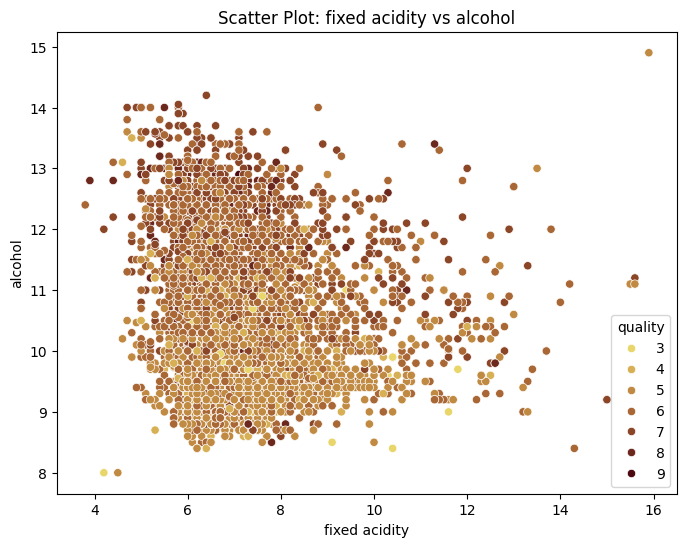

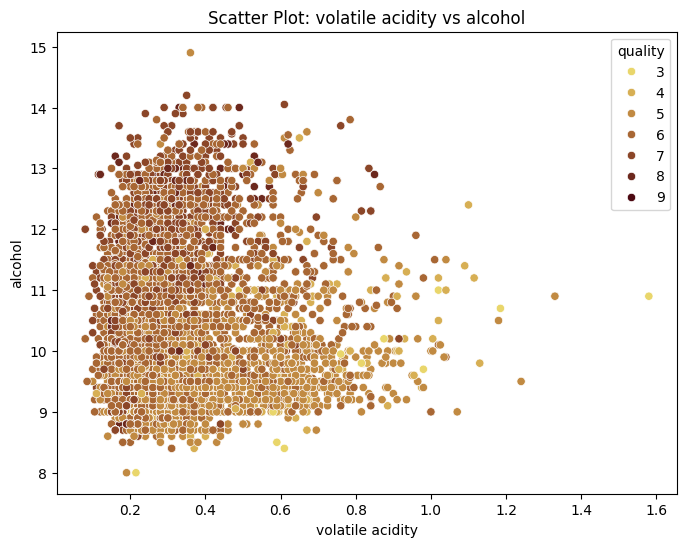

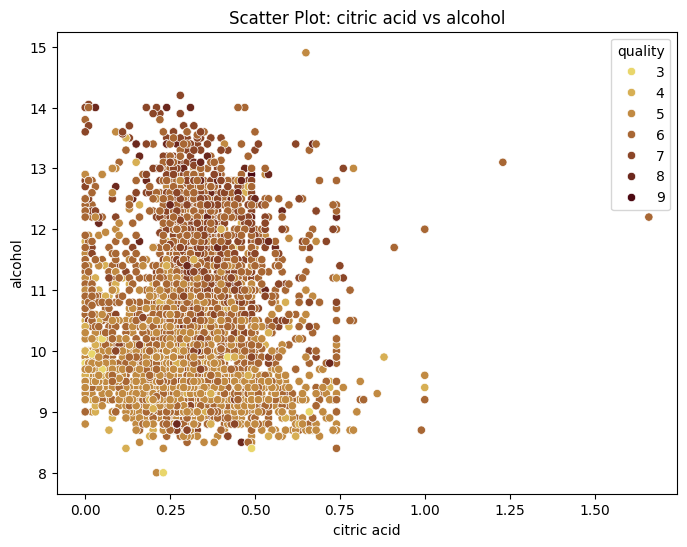

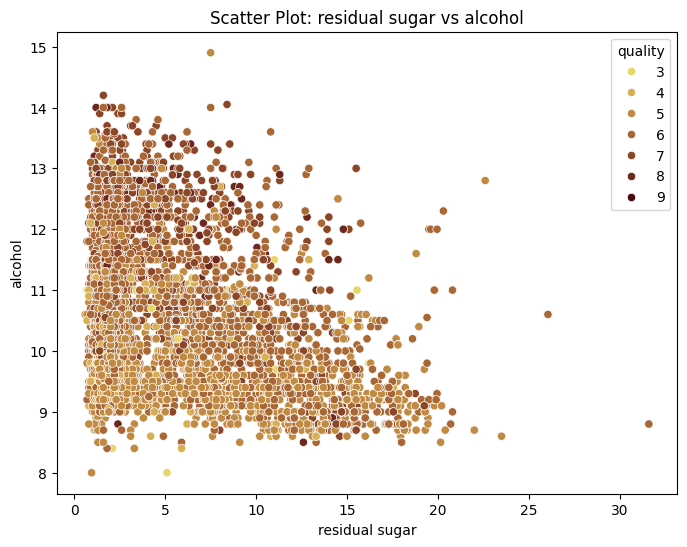

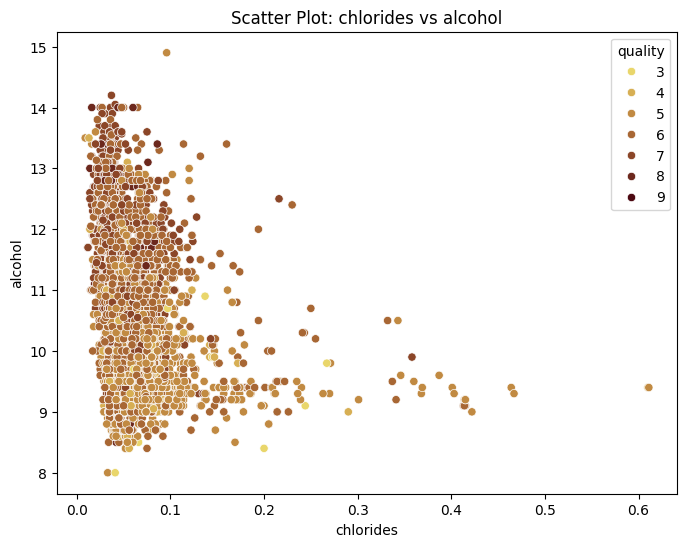

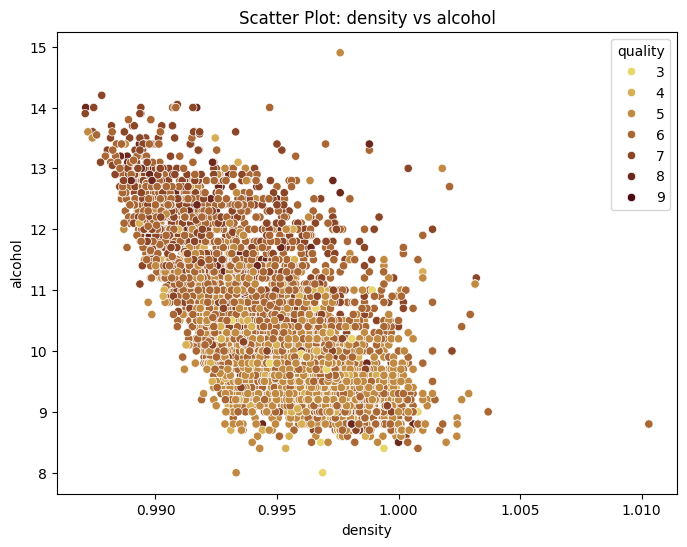

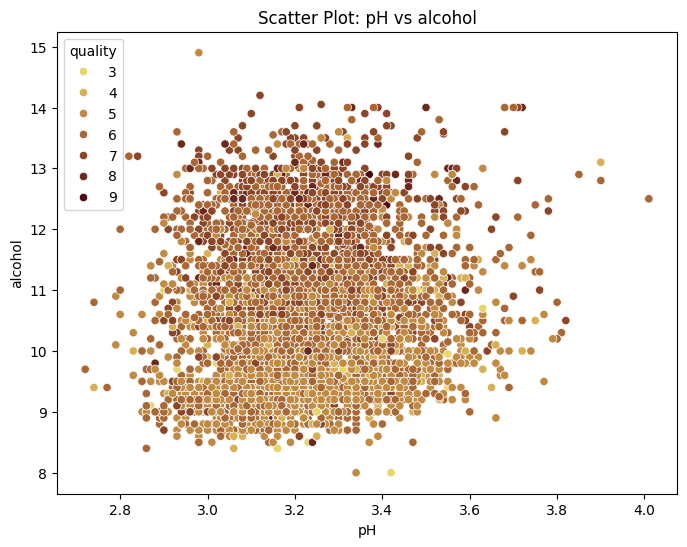

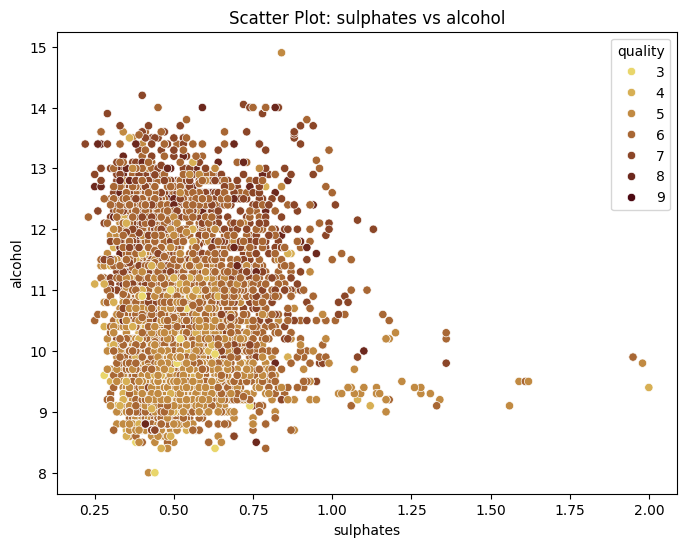

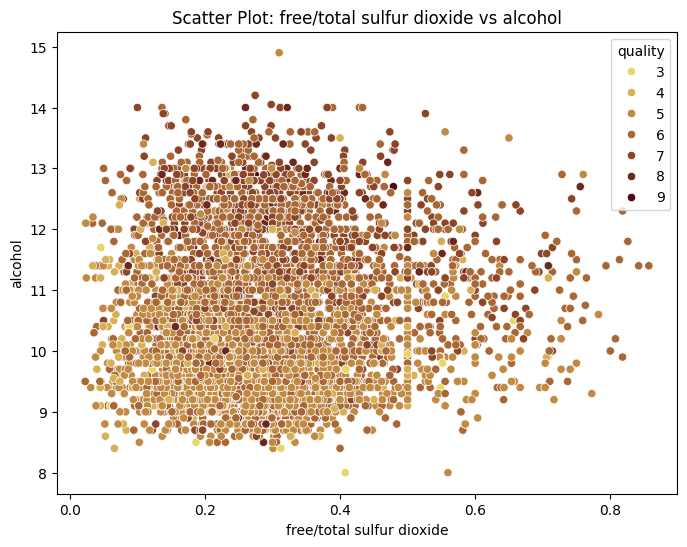

In [ ]:
import seaborn as sns

df_scatter = df_wine.drop(["color", "quality"], axis = 1)

target_column = "alcohol"

custom_palette = {
    9 : "#4c0911",
    8 : "#6c281d",
    7 : "#8b4628",
    6 : "#a86734",
    5 : "#c18a42",
    4 : "#d7af54",
    3 : "#e9d66b"
}

for column in df_scatter.columns:
  if column != target_column:
    plt.figure(figsize = (8,6))
    sns.scatterplot(x=column, y = target_column,
                    data = df_scatter, hue = df_wine["quality"],
                    palette = custom_palette, legend = "auto")
    plt.title(f"Scatter Plot: {column} vs {target_column}")
    plt.show

For most of these scatter plots, there seems to be only a weak relationship at best between the x variable and alcohol content. With that being said, higher alcohol content consistently ranks of a higher quality than lower alcohol content wines.

alt.Chart(...)

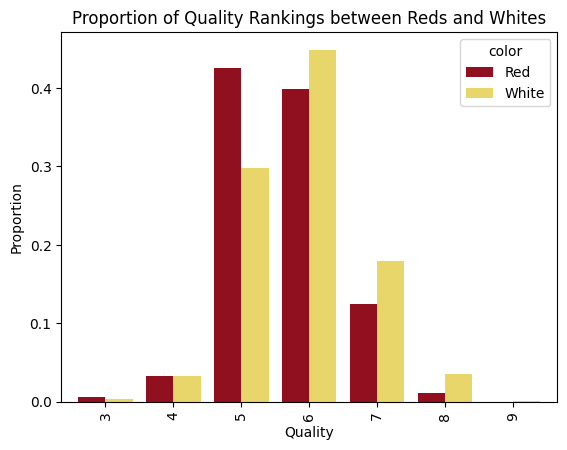

In [ ]:
total_proportion = pd.crosstab(
    df_wine["quality"],
    df_wine["color"],
    normalize = True
)

proportion_given_color = total_proportion.divide(
    total_proportion.sum(axis = 0),
    axis = 1
)

proportion_given_color.plot.bar(width = .8, color = ["#91101f", "#e9d66b"], xlabel = "Quality", ylabel = "Proportion", title = "Proportion of Quality Rankings between Reds and Whites")

wine_colors = alt.Scale(domain=["White", "Red"], range = ["#e9d66b", "#91101f"])

alt.data_transformers.disable_max_rows()

alt.Chart(df_wine).mark_bar().encode(
    x = alt.X("quality:N", axis = alt.Axis(title = "Quality")),
    y = alt.Y("count():Q", axis = alt.Axis(title = "Frequency")),
    color = alt.Color('color:N', scale = wine_colors)
).properties(
    title = "Wine Quality per Wine Color",
    height = 400,
    width = 300
)

There appears to be a slight preferences for white wines over reds (as seen by the quality proportion bar graph). Generally, there are slight differences over between the red and white wines in this data table, however for model simplicity we'll maintain the combined df_wine dataset, mostly to ensure robustness in later model calculation.

Text(0.5, 1.0, 'Correlation Matrix Heatmap for Wine Variables')

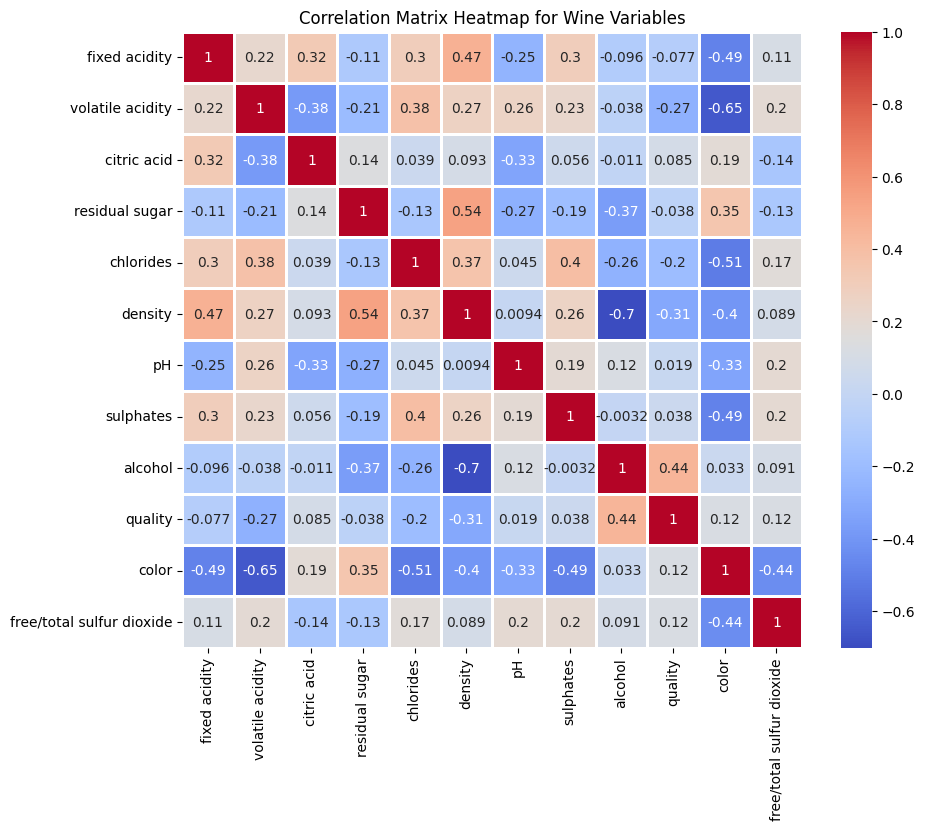

In [ ]:
df_wine["color"] = df_wine["color"].map({"White": 1, "Red": 0})
correlation_matrix = df_wine.corr()

plt.figure(figsize = (10,8))

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 1)

plt.title("Correlation Matrix Heatmap for Wine Variables")

Upon initial examination of the correlation matrix, there don't appear to be any variables with strong R values to our response variables of interest (alcohol and quality). With that being said, we will continue analysis to create predictive models below.

# Machine Learning Regression Models
##K Nearest Neighbors Regression Model

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


X_train = df_wine.drop(["alcohol", "quality", "color"], axis = 1)
y_train = df_wine["alcohol"]

# Define the parameter grid with different combinations of features
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9],
}

# Define the pipeline with explicit step names
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(f_regression)),
    ('kneighborsregressor', KNeighborsRegressor())
])

# Perform an exhaustive search over the parameter grid
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=KFold(n_splits=10, shuffle=True, random_state=42))
grid_search.fit(X_train, y_train)

# Retrieve the selected feature indices from SelectKBest
selected_feature_indices = grid_search.best_estimator_.named_steps['selectkbest'].get_support()

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Print the best feature combination
print("Selected Feature Names:", list(selected_feature_names))

Selected Feature Names: ['fixed acidity', 'residual sugar', 'chlorides', 'density', 'pH']


In [ ]:
from sklearn.pipeline import make_pipeline

#After best features were selected above
best_x_train = X_train[['fixed acidity', 'residual sugar', 'chlorides', 'density', 'pH']]

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5)
)

# Retrieve the ideal number of clusters from which kneighbors regression should occur
grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(best_x_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=10))])

<Axes: title={'center': 'kNN model with 7 features'}, xlabel='k', ylabel='test error'>

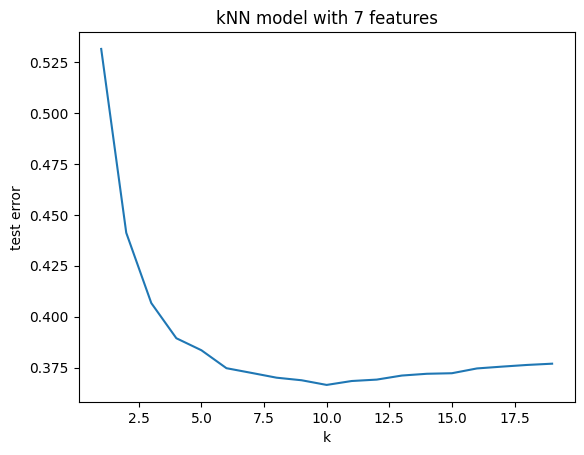

In [ ]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)

df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)

df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)

(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN model with 7 features")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Creating training and validation dataframes on a .75/.25 split ensuring that
#wine color is also represented in these dataframes in the same proporiton
train_wine, val_wine = train_test_split(df_wine, test_size = .25, stratify = df_wine["color"], random_state = 24)

#removing unnecessary columns
train_wine.drop(["color", "quality"], inplace = True, axis = 1)
val_wine.drop(["color", "quality"], inplace = True, axis = 1)

#based on gridsearchcv decision above
best_params_knn = ['fixed acidity', 'residual sugar', 'chlorides', 'density', 'pH']

knn_model = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=10) #as decided by the above scikitlearn calculation
)


knn_model.fit(X = train_wine[best_params_knn], y = train_wine["alcohol"])

prediction = pd.DataFrame(knn_model.predict(X = val_wine[best_params_knn]), columns = ["Predicted Alcohol"])

val_wine.reset_index(drop=True, inplace=True)

rmse = np.sqrt(mean_squared_error(val_wine["alcohol"], prediction))
rmse

0.5555213935377834

Although I'll use SciKitLearn's more robust method of calculating RMSE below, I decided to calculated it here to get a preliminary understanding of the strength of the knn and linear regression models.

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

# Define the parameter grid with different combinations of features
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Define the pipeline with explicit step names
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(f_regression)),
    ('kneighborsregressor', LinearRegression())
])

# Perform an exhaustive search over the parameter grid
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=KFold(n_splits=10, shuffle=True, random_state=42))
grid_search.fit(X_train, y_train)

# Retrieve the selected feature indices from SelectKBest
selected_feature_indices = grid_search.best_estimator_.named_steps['selectkbest'].get_support()

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Print the best feature combination
print("Selected Feature Names:", list(selected_feature_names))

Selected Feature Names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'density', 'pH', 'sulphates', 'free/total sulfur dioxide']


In [ ]:
best_params_lin = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'density', 'pH', 'sulphates', 'free/total sulfur dioxide']

linear_model = make_pipeline(
          StandardScaler(),
          LinearRegression()
)

linear_model.fit(X = train_wine[best_params_lin], y = train_wine["alcohol"])

prediction = pd.DataFrame(linear_model.predict(X = val_wine[best_params_lin]), columns = ["Predicted Alcohol"])

val_wine.reset_index(drop=True, inplace=True)
val_wine.reset_index(drop=True, inplace=True)

rmse = np.sqrt(mean_squared_error(val_wine["alcohol"], prediction))
rmse

0.5474527986821303

It initially appears as though the linear model outperforms the knn model based their respective RMSEs (knn: .556, linear: .547).

## Stacked Ensemble Model

To note: The best combination of parameters differed between the K Nearest Neighbors Model (5 parameters) and the Linear Regression Model (all 9 parameters). So for the sake of model simplicity and to avoid overfitting, I'll default to the 5 parameter layout.

Retrained Linear Model below.

In [ ]:
linear_model = make_pipeline(
          StandardScaler(),
          LinearRegression()
)

linear_model.fit(X = X_train[best_params_knn], y = y_train) #as mentioned above, choosing 5 params from knn

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor([
    ("linear", linear_model),
    ("knn", knn_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X=X_train[best_params_knn], y=y_train)

stacker = stacking_model.final_estimator_
stacker.intercept_, stacker.coef_

(0.3082873010759162, array([0.31469999, 0.66709381]))

The stacked ensemble model appears to prefer the knn_model far more heavily than the linear model. This can be seen in the model coefficients:

Alcohol-predicted = .308 + .315(Linear Model) + .667(K-Nearest Neighbors Model)

In [ ]:
from sklearn.model_selection import cross_val_score

for model in [linear_model, knn_model, stacking_model]:
    print(-cross_val_score(model, X=X_train[best_params_knn], y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean())

0.6121652769755764
0.4921809338410744
0.4705740166897826


In [ ]:
from sklearn.metrics import make_scorer, r2_score

# Use "r2" as the scoring method
scorer = make_scorer(r2_score)

for model in [linear_model, knn_model, stacking_model]:
    r2_score_result = cross_val_score(model, X=X_train[best_params_knn], y=y_train, cv=5, scoring=scorer).mean()
    print(f"R^2 Score for {type(model).__name__}: {r2_score_result}")


R^2 Score for Pipeline: 0.5059917346366207
R^2 Score for Pipeline: 0.6049159216798007
R^2 Score for StackingRegressor: 0.6196630579905598


Unsurprisingly, the stacked model produces the smallest RMSE, and subsequently, the strongest predictive model. However, the R^2 value of all models are very low, indicating **at best** that only 15.6% of the variability in alcohol content can be explained by our three models.

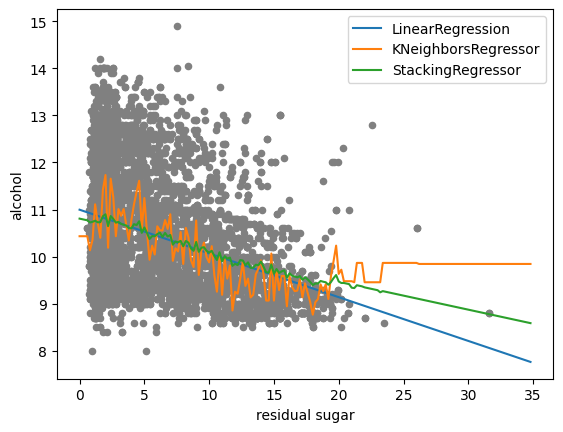

In [ ]:
df_wine.plot.scatter(x = "residual sugar", y = "alcohol", color = "gray")

for model in [LinearRegression(),
              KNeighborsRegressor(n_neighbors = 9),
              stacking_model]:
  model.fit(X = X_train[["residual sugar"]], y = y_train)
  X_test = pd.DataFrame({
                         "residual sugar": np.arange(0, 35, 0.2)
                         })
  predictions = pd.Series(
      model.predict(X_test),
      index = X_test["residual sugar"]
  )
  predictions.plot.line(legend = True, label = type(model).__name__)


Although difficult to discern, the results provided by the different RMSEs can be intuited from the scatter plot with model lines above. The K-nearest neighbors resgression model is hypersenitive to the noise of individual values in the dataset while the linear regression model appears too simplistic given the variability of the data. The stacking regression finds itself in that happy middle ground between capturing the "trend" of the data while still responding to individual datapoint volatility.

In [ ]:
#Testing how well the aforemetioned models peform against a model that simply predicts the mean
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_train, y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean()

1.458800304020342

As can be seen by the RMSE's of each of the three ML models, all of them perform significantly better than the dummy regressor.

# Machine Learning Classifier Models

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier

X_train = df_wine.drop(["quality", "color"], axis = 1)
y_train = df_wine["quality"]

# Define the parameter grid with different combinations of features
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
}

# Define the pipeline with explicit step names
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest(f_classif)),
    ('kneighborsclassifier', KNeighborsClassifier())
])

# Perform an exhaustive search over the parameter grid
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
grid_search.fit(X_train, y_train)

# Retrieve the selected feature indices from SelectKBest
selected_feature_indices = grid_search.best_estimator_.named_steps['selectkbest'].get_support()

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Print the best feature combination
print("Selected Feature Names:", list(selected_feature_names))

Selected Feature Names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'density', 'sulphates', 'alcohol', 'free/total sulfur dioxide']


Note: Regardless of sklearn's insistence on the usage of the parameters above, I will instead be using the three most highly correlated variables (as seen in the above correlation matrix). This is because sklearn's parameter reccomendation leads to selecting k = 1, an overfit model.

In [ ]:
from sklearn.model_selection import cross_val_predict

X_class_best = X_train[['volatile acidity', 'density', 'alcohol']]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kneighborsclassifier', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    pipeline,
    param_grid = {"kneighborsclassifier__n_neighbors" : range(1, 15)},
    scoring = "f1_macro",
    cv = 10
)

grid_search.fit(X_class_best, y_train)
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


{'kneighborsclassifier__n_neighbors': 6}

See previous note.

<Axes: title={'center': 'kNN model with 3 features'}, xlabel='k', ylabel='test error'>

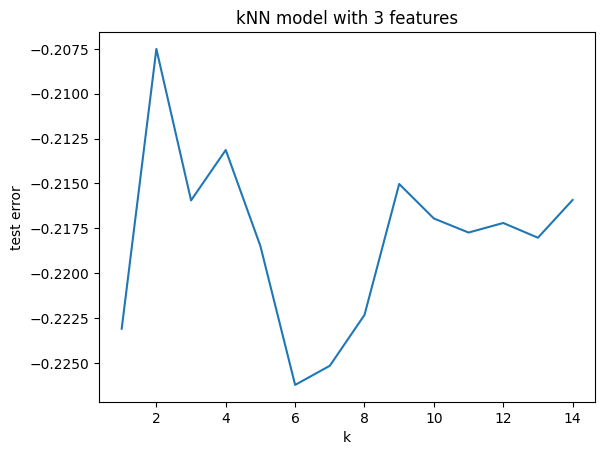

In [ ]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)

df_cv_results_["param_kneighborsclassifier__n_neighbors"] = df_cv_results_["param_kneighborsclassifier__n_neighbors"].astype(int)

df_cv_results_.set_index("param_kneighborsclassifier__n_neighbors", inplace = True)

(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN model with 3 features")

As seen in k-cluster graph above, 6 clusters minimizes the test error of the k-nearest neighbors model.

In [ ]:
#Creating training and validation dataframes on a .75/.25 split ensuring that
#wine color is also represented in these dataframes in the same proporiton
train_wine, val_wine = train_test_split(df_wine, test_size = .25, stratify = df_wine["color"], random_state = 24)

train_wine.drop(["color"], inplace = True, axis = 1)
val_wine.drop(["color"], inplace = True, axis = 1)

best_class_params = ['volatile acidity', 'density', 'alcohol']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kneighborsclassifier', KNeighborsClassifier(n_neighbors = 6))
])

pipeline.fit(X = train_wine[best_class_params], y = train_wine["quality"])

predictions = pipeline.predict(X = val_wine[best_class_params])


In [ ]:
pd.crosstab(val_wine["quality"], predictions, margins = True)

col_0     4    5    6    7   8   All
quality                             
3         1    4    4    0   0     9
4         7   30   17    4   0    58
5         9  345  145   11   1   511
6         4  237  378   77   2   698
7         0   41  163   87   4   295
8         0    4   31   13   4    52
9         0    0    1    0   0     1
All      21  661  739  192  11  1624

In [ ]:
import warnings
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

#Filtering out UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

precision_run = 0
recall_run = 0
f1_run = 0

#for each quality rating present in the data set, calculate the precision, recall, and f1 score
#across
#wine quality 9 values excluded due to NaN values produced
for qual in range(3, 8):

  score  = (val_wine["quality"] == qual)

  cv_precision = cross_val_score(pipeline, val_wine, score, cv=9, scoring="precision").mean()
  cv_recall = cross_val_score(pipeline, val_wine, score, cv=9, scoring="recall").mean()
  cv_f1 = cross_val_score(pipeline, val_wine, score, cv=9, scoring="f1").mean()

  precision_run = precision_run + cv_precision
  recall_run = recall_run + cv_recall
  f1_run = f1_run + cv_f1

  print("Precision for a wine rating of " + str(qual) + ": " + str(cv_precision))
  print("Recall for a wine rating of " + str(qual) + ": " + str(cv_recall))
  print("F1 for a wine rating of " + str(qual) + ": " + str(cv_f1), end = "\n\n")

print("Mean Precision:" + str(precision_run / 7))
print("Mean Recall:" + str(recall_run / 7))
print("Mean F1:" + str(f1_run / 7))

Precision for a wine rating of 3: 0.0
Recall for a wine rating of 3: 0.0
F1 for a wine rating of 3: 0.0

Precision for a wine rating of 4: 0.6666666666666666
Recall for a wine rating of 4: 0.10582010582010581
F1 for a wine rating of 4: 0.18253968253968253

Precision for a wine rating of 5: 0.8783546502157562
Recall for a wine rating of 5: 0.880708716235032
F1 for a wine rating of 5: 0.8790097339105729

Precision for a wine rating of 6: 0.9197895810455982
Recall for a wine rating of 6: 0.9012099012099011
F1 for a wine rating of 6: 0.9101171375170485

Precision for a wine rating of 7: 0.8958364722315407
Recall for a wine rating of 7: 0.8068181818181819
F1 for a wine rating of 7: 0.8483773679183956

Mean Precision:0.4800924814513659
Mean Recall:0.3849367007261744
Mean F1:0.4028634174122428


As can be seen in the quality splits, the k-nearest neighbors model struggles with classifying wines on the low or high end of the wine quality distribution. As can be seen in prior visualizations, much of the data is clustered in the center, implying the knn model places significant imporatnce on the middle-of-the-road quality wines. Because of this, the model succeeds in producing high precision, recall, and f1 values for wines with a rating between 5 and 7.

Unfortunately, the overall predictive capabilities appear weak seeing as the model **never** predicted a point to be classified graded as 3 or 8.

Precision breakdown for quality rankings (4-8)

*  66.7% of the wines predicted to be given a quality score of 4 were actually given so.
*  87.8%% of the wines predicted to be given a quality score of 5 were actually given so.
*  92.0% of the wines predicted to be given a quality score of 6 were actually given so.
*  89.6% of the wines predicted to be given a quality score of 7 were actually given so.
*  55.6% of the wines predicted to be given a quality score of 8 were actually given so.


<function matplotlib.pyplot.show(close=None, block=None)>

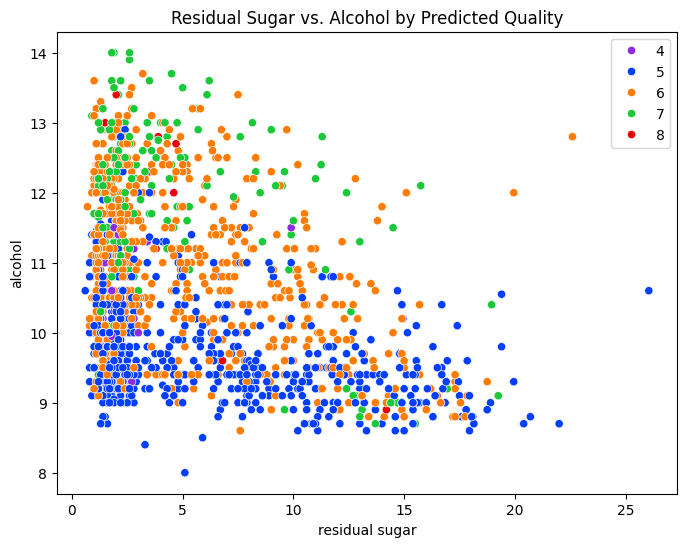

In [ ]:
bright_palette = sns.color_palette("bright", n_colors = 7)

category_color_map = dict(zip(val_wine["quality"].unique(), bright_palette))

plt.figure(figsize = (8,6))
sns.scatterplot(x="residual sugar", y = "alcohol",
                data = val_wine, hue = predictions,
                palette = category_color_map, legend = "auto")
plt.title(f"Residual Sugar vs. Alcohol by Predicted Quality")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

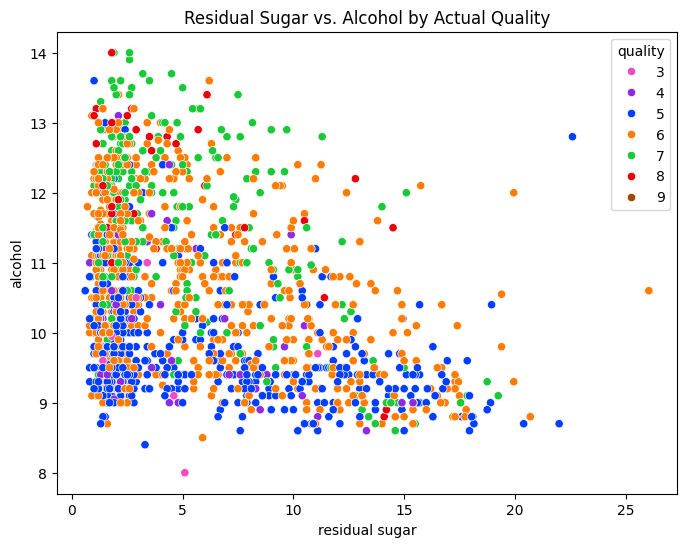

In [ ]:
plt.figure(figsize = (8,6))
sns.scatterplot(x="residual sugar", y = "alcohol",
                data = val_wine, hue = "quality",
                palette = category_color_map, legend = "auto")
plt.title(f"Residual Sugar vs. Alcohol by Actual Quality")
plt.show

Although the comparison between the actual and predicted quality scatter plots shows significant discrepencies (can also be inferred from previous model analysis), the model is moderately successful at discerning the differences beteen quality of rank 5, 6, and 7.


## Unsupervised Heriarchical Clustering Model

In [ ]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=54ce704aca12cb8f1474c47c31e2becae6e77c84be462d80ddeba4a44bc55d15
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting 

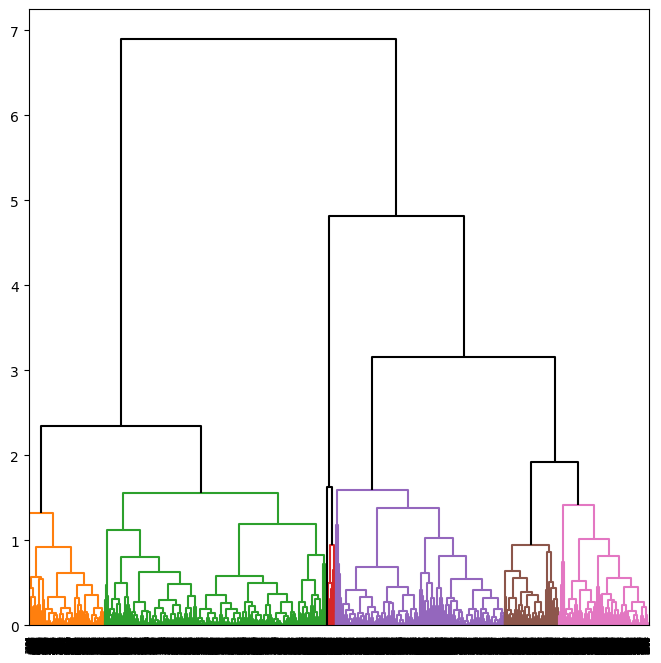

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from ISLP.cluster import compute_linkage

hc_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete")
hc_complete.fit(X_class_best)

linkage_complete = compute_linkage(hc_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_complete,
           ax=ax,
           color_threshold= 1.6,
           above_threshold_color='black');

<function matplotlib.pyplot.show(close=None, block=None)>

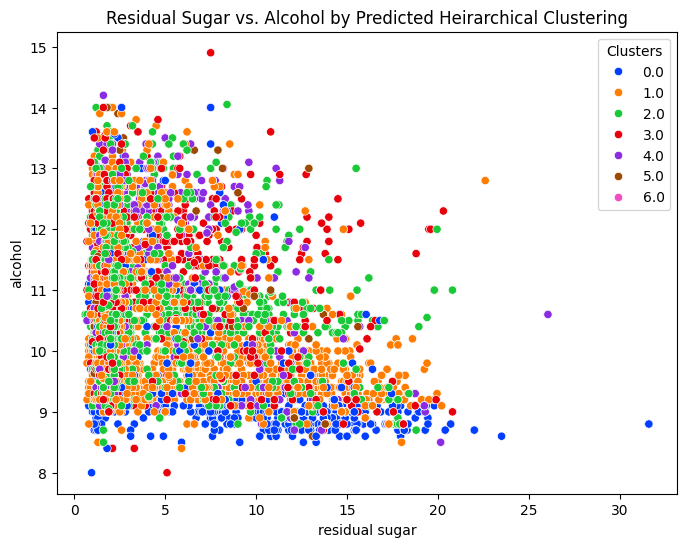

In [ ]:
from scipy.cluster.hierarchy import cut_tree

clusters_ = pd.Series(cut_tree(linkage_complete, n_clusters=7).T[0])

plt.figure(figsize = (8,6))
scatter_plot = sns.scatterplot(x="residual sugar", y = "alcohol",
                data = df_wine, hue = clusters_,
                palette = "bright", legend = "auto")

scatter_plot.legend(title='Clusters')

plt.title(f"Residual Sugar vs. Alcohol by Predicted Heirarchical Clustering")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

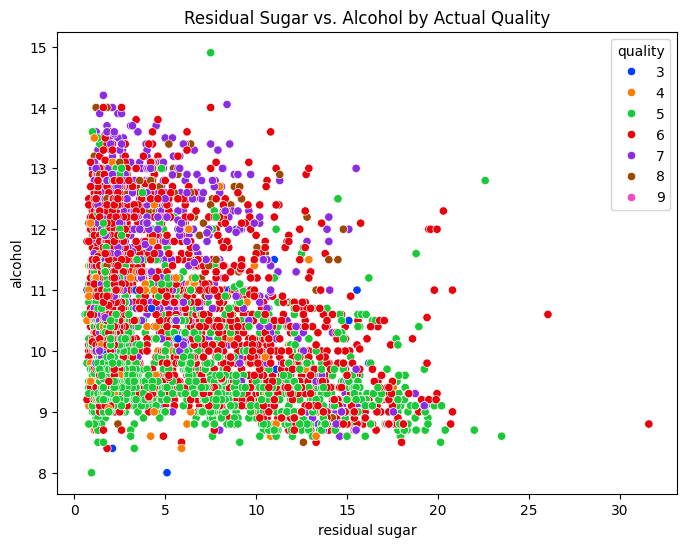

In [ ]:
plt.figure(figsize = (8,6))
sns.scatterplot(x="residual sugar", y = "alcohol",
                data = df_wine, hue = df_wine["quality"],
                palette = "bright", legend = "auto")

plt.title(f"Residual Sugar vs. Alcohol by Actual Quality")
plt.show

This unsupervised heirarchical clustering method clearly demonstrates the inability of unsupervised machine learning models to handle such extreme instances of classification overlap.

For example, notice in the predicted heirarchical classification graph, the point that sits at roughly (5,8). 5 $g/dm^3$ of residual sugar with an ABV of ~8% is indicative of a low-sweetness and low-richness wine. The heirarchical clustering model claims that this same point is of a similar quality/taste as a wine at 20 $g/dm^3$ and ~12.5% ABV, ~1.5 $g/dm^3$ and ~10% ABV, and ~7.5 $g/dm^3$ and ~15% ABV.